## semi - supervised learning을 위한 문장 분류 모델

현재 데이터가 labeling이 되어있지 않은 상태고 labeling을 수기로 하지 않고 모델을 이용해서 할 것이다. 
따라서 문장을 classification하는 model을 설계할 것이다. 

### 1. data 불러오기
to_label.ipynb 파일을 이용해서 label을 위한 데이터를 만들어뒀다.
이를 불러와서 classification하는 모델을 만들어보자!

In [20]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

import matplotlib.pyplot as plt
import csv

In [21]:
class SentenceDataset(Dataset) :
    def __init__(self, sentences, labels = None) :
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self) :
        return len(self.sentences)
    
    def __getitem__(self, index) :
        sentence = self.sentences[index]
        inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        if self.labels is not None : 
            label = self.labels[index]
            return input_ids, attention_mask, torch.tensor(label)
        else : 
            return input_ids, attention_mask

In [22]:
label_data_path = "./dataset/handmade_data.csv"
csv_data = pd.read_csv(label_data_path)

In [23]:
csv_data.columns
len(csv_data)
csv_data[csv_data['label']==8]

,id,sentence,label
700,700,홍익대학교는 언제 설립되었나요?,8
701,701,홍익대학교의 설립자는 누구인가요?,8
702,702,홍익대학교의 주요 학과는 무엇인가요?,8
703,703,홍익대학교의 캠퍼스는 어디에 위치해 있나요?,8
704,704,홍익대학교의 대표적인 학문 분야는 무엇인가요?,8
...,...,...,...
825,825,홍익대학교의 학과별 진로 상담은 어떻게 이루어지나요?,8
826,826,홍익대학교의 교내 예술 작품 전시는 어떻게 이루어지나요?,8
827,827,홍익대학교의 학내 안전 교육은 어떻게 받나요?,8
828,828,홍익대학교의 캠퍼스 내 편의점은 어디에 있나요?,8


In [24]:
csv_data['sentence']

0                         학식 메뉴는 매일 바뀌나요?
1      학식에서 제공하는 음식은 영양적으로 균형이 잘 맞춰져 있나요?
2                   대학교 학식의 평균 가격은 얼마인가요?
3                   채식주의자를 위한 메뉴 옵션이 있나요?
4                      학식에서 국제 음식을 제공하나요?
                      ...                
925            졸업 논문 제출 후 심사 과정은 어떻게 되나요?
926              졸업에 필요한 필수 교양 과목은 무엇인가요?
927               졸업 요건 중 팀 프로젝트 발표가 있나요?
928         졸업을 위해 필요한 필수 인턴십 성적 기준이 있나요?
929             졸업 논문 작성 시 필요한 자료는 무엇인가요?
Name: sentence, Length: 930, dtype: object

In [25]:
# 패딩 적용
def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    attention_masks = [item[1] for item in batch]
    

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    if len(batch[0]) == 3 :
        labels = [item[2] for item in batch]
        labels = torch.stack(labels)
        return input_ids, attention_masks, labels
    else : 
        return input_ids, attention_masks

In [26]:
dataset = SentenceDataset(csv_data['sentence'], csv_data['label'])
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn,drop_last=True)

In [27]:
print(len(dataset))
print(dataset[100] )
print(dataset[105])

930
(tensor([  101,  1469, 30006, 30020, 29991, 30013, 29999, 30018,  1468, 30010,
        30021, 29999, 30018, 29997, 30019, 29997, 30008, 30022, 29999, 30017,
        30021,  1464, 30014, 29994, 30011,   100,   100,   100,  1029,   102]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]), tensor(2))
(tensor([  101,  1468, 30010, 30021, 29999, 30018, 29997, 30019, 29997, 30008,
        30022,  1464, 30014, 30025, 29999, 30009, 29997, 30008,  1469, 30006,
        30020, 29997, 30007, 30025, 29993, 30017, 30022, 29999, 30019,  1455,
        30006, 30000, 30006, 30025,   100,  1463, 30019, 29999, 30013, 30025,
        30005, 30006, 29992, 30017, 30021,   100,  1463, 30008, 29993, 30019,
        29999, 30019, 30021, 29991, 30006, 29999, 30013,  1029,   102]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1,

### 2. bert를 이용한 sentenceClassifier

In [28]:
class SentenceClassifier(nn.Module) :
    def __init__(self, num_labels) :
        super(SentenceClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_labels)

    def forward(self, input_ids, attention_mask) :
        outputs = self.bert(input_ids=input_ids, attention_mask = attention_mask)
        return outputs.logits

In [29]:
model = SentenceClassifier(10)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
# optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3. train model

In [30]:
def train_model(model, dataloader, criterion, optimizer, epochs = 5) :
    model.train()
    epoch_losses = []
    for epoch in range(epochs) :
        epoch_loss = 0
        for input_ids, attention_mask, labels in dataloader :
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_losses.append(epoch_loss / len(dataloader))
        print(f"Epoch {epoch+1}, Loss : {loss.item()}")
    return epoch_losses

In [31]:
def plot_losses(losses) : 
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Loss : 0.9290310144424438
Epoch 2, Loss : 0.6348378658294678
Epoch 3, Loss : 0.24706882238388062
Epoch 4, Loss : 0.29424646496772766
Epoch 5, Loss : 0.06893549859523773
Epoch 6, Loss : 0.18637357652187347
Epoch 7, Loss : 0.5173147320747375
Epoch 8, Loss : 0.0157772246748209
Epoch 9, Loss : 0.013372169807553291
Epoch 10, Loss : 0.0442805215716362


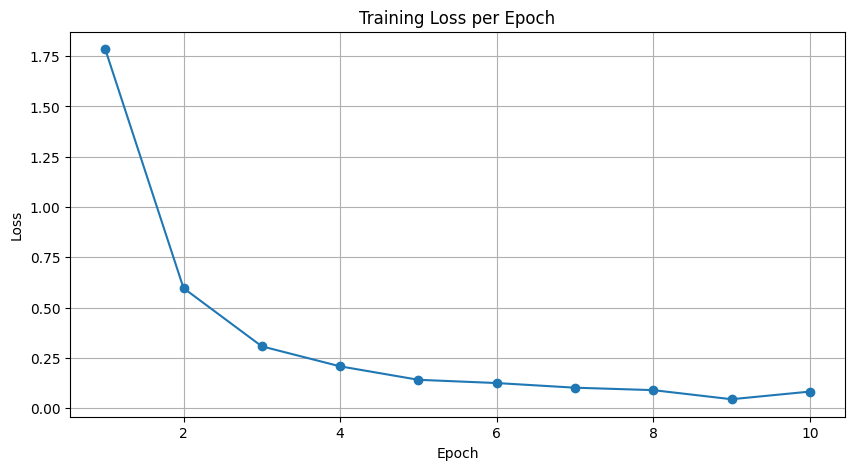

In [32]:
epoch_losses = train_model(model, dataloader, criterion, optimizer, 10) 
plot_losses(epoch_losses)

### evaluate model

In [33]:
def evaluate_model(model, dataloader) :
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad() :
        for input_ids, attention_mask, labels in dataloader :
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy : {correct / total * 100:.2f}%")

In [34]:
evaluate_model(model, dataloader)

Accuracy : 98.28%


### 4. test model
label이 붙지 않은 데이터를 넣어보며 테스트를 해보자. 

In [35]:
# 테스트 데이터 (라벨이 없는 경우)
test_sentences = [
    "홍익대학교는 이사장이 이면영입니까?.",
    "학식이 맛있는지 아닌지 어떻게 알죠?",
    "홍익대학교는 명문 대학교입니다.",
    "홍익대학교 pc실이 어디였죠?",
    "홍익대학교 스케쥴이 궁금합니다.",
    "컴공 과사무실 번호 좀 알려주세요",
    "회화과 공지사항 좀 보여줘",
    "오늘 비가 올까?",
    "열람실 자리가 있어?",
    "졸업 요건이 뭐가 부족한지 알고싶어"
]


In [36]:
test_dataset = SentenceDataset(test_sentences)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [37]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [38]:
test_predictions = predict(model, test_dataloader)
for sentence, prediction in zip(test_sentences, test_predictions) : 
    print(f"Sentence: {sentence}\t Prediction: {prediction}\n")

Sentence: 홍익대학교는 이사장이 이면영입니까?.	 Prediction: 8

Sentence: 학식이 맛있는지 아닌지 어떻게 알죠?	 Prediction: 1

Sentence: 홍익대학교는 명문 대학교입니다.	 Prediction: 8

Sentence: 홍익대학교 pc실이 어디였죠?	 Prediction: 6

Sentence: 홍익대학교 스케쥴이 궁금합니다.	 Prediction: 6

Sentence: 컴공 과사무실 번호 좀 알려주세요	 Prediction: 3

Sentence: 회화과 공지사항 좀 보여줘	 Prediction: 5

Sentence: 오늘 비가 올까?	 Prediction: 6

Sentence: 열람실 자리가 있어?	 Prediction: 7

Sentence: 졸업 요건이 뭐가 부족한지 알고싶어	 Prediction: 9



### 5. model save

모델을 저장하자

In [40]:
save_path = "label_class_model"
torch.save(model.state_dict(), save_path)